In [1]:
%matplotlib inline

import numpy as np

import matplotlib.image as mpimg

import matplotlib.pyplot as plt

import matplotlib.cm as cm

import png

import scipy.ndimage as ndimage

from scipy.misc import imsave, imshow

from scipy.ndimage import filters

import pyopencl as cl

In [2]:
# Our starting image
img = ndimage.imread('./eed-noise.png')
# extract red channel
img = img[:,:,0]
height, width = img.shape

In [3]:
def show(img, height=height, width=width):
    plt.imshow(img.reshape(height,width), cm.Greys_r, interpolation='none', vmin = 0, vmax = 255)

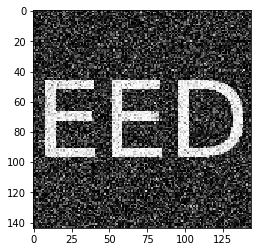

In [4]:
show(img)

In [5]:
def createBlurMask(sigma):
    maskSize = int(np.ceil(3.0*sigma))
    mask = np.zeros((maskSize*2+1, maskSize*2+1))
    
    maskSum = 0.0
    for a in xrange(-maskSize, maskSize+1):
        for b in xrange(-maskSize, maskSize+1):
            temp = np.exp(-( float(a*a + b*b) / (2*sigma*sigma) ))
            maskSum += temp
            mask[a+maskSize, b+maskSize] = temp
            
    # Normalize
    mask = mask / maskSum
    
    return mask, maskSize
    
    

In [9]:
mask, maskSize = createBlurMask(40.0)

#ctx = cl.create_some_context()
platforms = cl.get_platforms()
ctx = cl.Context(
        dev_type=cl.device_type.GPU,
        properties=[(cl.context_properties.PLATFORM, platforms[0])])
print ctx
queue = cl.CommandQueue(ctx)

mf = cl.mem_flags

img_g = cl.Buffer(ctx, mf.READ_ONLY  | mf.COPY_HOST_PTR, hostbuf=img.astype(np.float32))
blurred_img_g = cl.Buffer(ctx, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=img.astype(np.float32))
mask_g = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=mask.astype(np.float32))

prg = cl.Program(ctx, """
__kernel void gaussian_blur(__global float * img_g, __constant float * mask, __private const int maskSize,
                            __global float * blurred_img_g)
{
  const int posx = get_global_id(0);
  const int posy = get_global_id(1);
  
  float sum = 0.0f;
  
  for (int a = -maskSize; a < maskSize+1; a++) {
    for (int b = -maskSize; b < maskSize+1; b++) {
      const int imgpos = clamp(posx+a, 0, 144) + clamp(posy+b, 0, 144)*144;
      sum += mask[a+maskSize + (b+maskSize)*(maskSize*2+1)] * img_g[imgpos];
    }
  }
  
  blurred_img_g[posx+posy*get_global_size(0)] = sum;
}


""").build()

kernel = prg.gaussian_blur
kernel.set_scalar_arg_dtypes( [None, None, np.int32, None] )
kernel(queue, img.shape, None, img_g, mask_g, maskSize, blurred_img_g)

result_np = np.empty_like(img).astype(np.float32)
cl.enqueue_copy(queue, result_np, blurred_img_g)

# Show results
show(result_np)
print result_np.shape

<pyopencl.Context at 0x7fbfadce1b90 on <pyopencl.Device 'Intel(R) Iris(TM) Graphics 6100' on 'Apple' at 0x1024500>>


RuntimeError: clEnqueueNDRangeKernel failed: OUT_OF_RESOURCES

In [7]:
cl.get_platforms()[0].get_devices()

[<pyopencl.Device 'Intel(R) Core(TM) i7-5557U CPU @ 3.10GHz' on 'Apple' at 0xffffffff>,
 <pyopencl.Device 'Intel(R) Iris(TM) Graphics 6100' on 'Apple' at 0x1024500>]

In [30]:
cl.get_supported_image_formats(ctx, cl.mem_flags.READ_ONLY, cl.mem_object_type.IMAGE2D)

[ImageFormat(INTENSITY, FLOAT),
 ImageFormat(RGBA, FLOAT),
 ImageFormat(RGBx, FLOAT),
 ImageFormat(RGx, FLOAT),
 ImageFormat(Rx, FLOAT),
 ImageFormat(INTENSITY, HALF_FLOAT),
 ImageFormat(RGBA, HALF_FLOAT),
 ImageFormat(RGBx, HALF_FLOAT),
 ImageFormat(RGBA, <unknown channel data type 0x10000008>),
 ImageFormat(RGBA, SIGNED_INT16),
 ImageFormat(RGBA, SIGNED_INT32),
 ImageFormat(RGBA, SIGNED_INT8),
 ImageFormat(RGBA, SNORM_INT16),
 ImageFormat(RGBA, SNORM_INT8),
 ImageFormat(RGBA, UNSIGNED_INT16),
 ImageFormat(RGBA, UNSIGNED_INT32),
 ImageFormat(RGBA, UNSIGNED_INT8),
 ImageFormat(RGBA, UNORM_INT16),
 ImageFormat(RGBx, UNORM_INT16),
 ImageFormat(<unknown channel order 0x10000006>, UNORM_INT8),
 ImageFormat(A, UNORM_INT8),
 ImageFormat(<unknown channel order 0x10b7>, UNORM_INT8),
 ImageFormat(<unknown channel order 0x10000007>, UNORM_INT8),
 ImageFormat(BGRA, UNORM_INT8),
 ImageFormat(INTENSITY, UNORM_INT8),
 ImageFormat(RGBA, UNORM_INT8),
 ImageFormat(RGBx, UNORM_INT8),
 ImageFormat(RGx, U

<pyopencl.Context at 0x7fbfab5e1e40 on <pyopencl.Device 'Intel(R) Iris(TM) Graphics 6100' on 'Apple' at 0x1024500>>


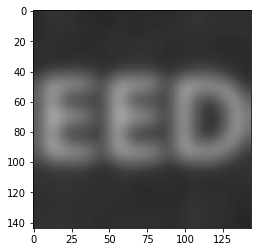

In [14]:
#ctx = cl.create_some_context()
platforms = cl.get_platforms()
ctx = cl.Context(
        dev_type=cl.device_type.GPU,
        properties=[(cl.context_properties.PLATFORM, platforms[0])])
print ctx
queue = cl.CommandQueue(ctx)

mf = cl.mem_flags

u_g = cl.Buffer(ctx, mf.READ_ONLY  | mf.COPY_HOST_PTR, hostbuf=img.astype(np.float32))
d_g = cl.Buffer(ctx, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=img.astype(np.float32))

prg = cl.Program(ctx, """
__constant float dt = 0.1;

inline int2 reflect(int2 i, const int h, const int w) {
  int2 ret = i;
  if (i.x < 0) {
    ret.x = abs(i.x);
  }
  if (i.x > w - 1) {
    ret.x = w - 1 - (i.x - (w - 1));
  }
  if (i.y < 0) {
    ret.y = abs(i.y);
  }
  if (i.y > h - 1) {
    ret.y = h - 1 - (i.y - (h - 1));
  }
  return ret;
}

inline float getpixel(const __global float * arr, const int2 pos, const int w) {
  return arr[pos.x + pos.y*w];
}

__kernel void linear_homogeneous(__global float * u_g,
                                 __global float * d_g)
{
    const int2 pos = {get_global_id(0), get_global_id(1)};
    const int width = get_global_size(0);
    const int height = get_global_size(1);

    const int2 left_i  = reflect(pos + (int2)(-1,  0), height, width);
    const int2 right_i = reflect(pos + (int2)( 1,  0), height, width);
    const int2 up_i    = reflect(pos + (int2)( 0, -1), height, width);
    const int2 down_i  = reflect(pos + (int2)( 0,  1), height, width);

    const float left  = getpixel(u_g, left_i,  width);
    const float right = getpixel(u_g, right_i, width);
    const float up    = getpixel(u_g, up_i,    width);
    const float down  = getpixel(u_g, down_i,  width);

    d_g[pos.x + pos.y*width] = left + right + up + down - (4.0 * getpixel(u_g, pos, width));

    u_g[pos.x + pos.y*width] += d_g[pos.x + pos.y*width] * dt;
}


""").build()

kernel = prg.linear_homogeneous
for i in xrange(0,200):
    kernel(queue, img.shape, None, u_g, d_g)

result_np = np.empty_like(img).astype(np.float32)
cl.enqueue_copy(queue, result_np, u_g)

# Show results
show(result_np)

<pyopencl.Context at 0x7fbfab5aa2c0 on <pyopencl.Device 'Intel(R) Iris(TM) Graphics 6100' on 'Apple' at 0x1024500>>
CPU times: user 123 ms, sys: 27 ms, total: 150 ms
Wall time: 158 ms


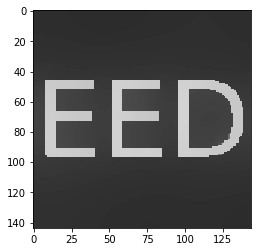

In [25]:
%%time
platforms = cl.get_platforms()
ctx = cl.Context(
        dev_type=cl.device_type.GPU,
        properties=[(cl.context_properties.PLATFORM, platforms[0])])
print ctx
queue = cl.CommandQueue(ctx)

mf = cl.mem_flags
u = ndimage.gaussian_filter(img, sigma=1)

u_g = cl.Buffer(ctx, mf.READ_ONLY  | mf.COPY_HOST_PTR, hostbuf=u.astype(np.float32))
d_g = cl.Buffer(ctx, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=img.astype(np.float32))

prg = cl.Program(ctx, """
__constant float dt = 0.1;
//__constant float edge_threshold = 5.0; 
__constant float lsq = 25.0; //edge_threshold*edge_threshold;

inline float perona_malik_diffusivity(const float grad) {
    return 1.0/(1.0 + (grad*grad)/lsq);
}

inline int2 reflect(int2 i, const int h, const int w) {
  int2 ret = i;
  if (i.x < 0) {
    ret.x = abs(i.x);
  }
  if (i.x > w - 1) {
    ret.x = w - 1 - (i.x - (w - 1));
  }
  if (i.y < 0) {
    ret.y = abs(i.y);
  }
  if (i.y > h - 1) {
    ret.y = h - 1 - (i.y - (h - 1));
  }
  return ret;
}

inline float getpixel(const __global float * arr, const int2 pos, const int w) {
  return arr[pos.x + pos.y*w];
}

__kernel void nonlinear_isotropic(__global float * u_g,
                                 __global float * d_g)
{
    const int2 pos = {get_global_id(0), get_global_id(1)};
    const int width = get_global_size(0);
    const int height = get_global_size(1);

    const int2 left_i  = reflect(pos + (int2)(-1,  0), height, width);
    const int2 right_i = reflect(pos + (int2)( 1,  0), height, width);
    const int2 up_i    = reflect(pos + (int2)( 0, -1), height, width);
    const int2 down_i  = reflect(pos + (int2)( 0,  1), height, width);

    const float center  = getpixel(u_g, pos, width);
    const float d_left  = getpixel(u_g, left_i,  width) - center;
    const float d_right = getpixel(u_g, right_i, width) - center;
    const float d_up    = getpixel(u_g, up_i,    width) - center;
    const float d_down  = getpixel(u_g, down_i,  width) - center;
    
    const float g_left  = perona_malik_diffusivity(d_left);
    const float g_right = perona_malik_diffusivity(d_right);
    const float g_up    = perona_malik_diffusivity(d_up);
    const float g_down  = perona_malik_diffusivity(d_down);

    d_g[pos.x + pos.y*width] = g_left*d_left + g_right*d_right + g_up*d_up + g_down*d_down;

    u_g[pos.x + pos.y*width] += d_g[pos.x + pos.y*width] * dt;
}


""").build()

kernel = prg.nonlinear_isotropic
for i in xrange(0,10*200):
    kernel(queue, img.shape, None, u_g, d_g)

result_np = np.empty_like(img).astype(np.float32)
cl.enqueue_copy(queue, result_np, u_g)

# Show results
show(result_np)